In [2]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
import random


In [13]:
#monte carlo update with complete average or expectation
env = gym.make("Pendulum-v1", render_mode=None)

num_theta_bins = 51
num_theta_dot_bins = 51
num_action_bins =5

#arrays for these descrite states and actions
theta_bins = np.linspace(-np.pi, np.pi, num_theta_bins, dtype=np.float32)
theta_dot_bins = np.linspace(-8, 8, num_theta_dot_bins, dtype=np.float32)
action_bins = np.linspace(-2.0, 2.0, num_action_bins, dtype=np.float32)

#creating a descrite bins
#hyper parameters
num_episodes = 30000 #num of epi to train
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.00001
stepsize_alpha = 0.1 

#action value matrix
Q = np.zeros((num_theta_bins, num_theta_dot_bins, num_action_bins))
Policy = np.zeros((num_theta_bins, num_theta_dot_bins))
return_count = np.zeros((num_theta_bins, num_theta_dot_bins, num_action_bins))

def epsilon_greedy_policy(theta_idx, theta_dot_idx, Q, epsilon, action_bins):
    if random.uniform(0, 1) < epsilon: #explore
        return env.action_space.sample() 
    
    else:
        return action_bins[np.argmax(Q[theta_idx, theta_dot_idx])] #choose greddy
    
for i_episode in range(1, num_episodes + 1):
    episode = [] #to save current episode history
    state, info = env.reset()
    terminated = False
    truncated = False

    #Epsilon decay
    epsilon = max(epsilon_end, epsilon_start - epsilon_decay*i_episode)

    while (not terminated and not truncated):
        #the observation = [sin(theta), cos(theta), theta_dot]
        theta = np.arctan2(state[1], state[0])
        theta_idx = np.digitize(theta, theta_bins) - 1

        theta_dot = state[2]
        theta_dot_idx = np.digitize(theta_dot, theta_dot_bins) - 1
        
        action = epsilon_greedy_policy(theta_idx, theta_dot_idx, Q, epsilon, action_bins)
        action_idx = np.digitize(action, action_bins) - 1

        next_state, reward, terminated, truncated, info = env.step([action])

        #store the state, action, reward
        episode.append((theta_idx, theta_dot_idx, action_idx, reward))

        state = next_state

    #monte carlo update
    G = 0 #total return for current episode

    for t in reversed(range(len(episode))):
        theta_idx_t, theta_dot_idx_t, action_idx_t, reward_t = episode[t]

        #update the total retunr
        G = reward_t + gamma * G

        #for every visit counter
        return_count[theta_idx_t, theta_dot_idx_t, action_idx_t] += 1.0

        #update Q values
        current_Q = Q[theta_idx_t, theta_dot_idx_t, action_idx_t]
        Q[theta_idx_t, theta_dot_idx_t, action_idx_t] = current_Q + (1/return_count[theta_idx_t, theta_dot_idx_t, action_idx_t]) * (G - current_Q)
        #Q[state_t][action_t] = current_Q + (stepsize_alpha) * (G - current_Q)

    #progress report
    if i_episode % 1000 == 0:
        print(f"\nEpisode {i_episode}/{num_episodes}, Epsilon: {epsilon:.4f}")    

        Policy = np.argmax(Q, axis=2)

        #Evaluate the learned policy
        print("Evaluating learned policy...")
        total_rewards = 0
        num_eval_episodes = 100

        for _ in range(num_eval_episodes):
            state, info = env.reset()
            terminated = False
            truncated = False
            episode_reward = 0

            while (not terminated and not truncated):
                #the observation = [sin(theta), cos(theta), theta_dot]
                theta = np.arctan2(state[1], state[0])
                theta_idx = np.digitize(theta, theta_bins) - 1

                theta_dot = state[2]
                theta_dot_idx = np.digitize(theta_dot, theta_dot_bins) - 1

                # For evaluation, use a greedy policy (no exploration)
                action_idx = Policy[theta_idx, theta_dot_idx]
                action = action_bins[action_idx]
                next_state, reward, terminated, truncated, info = env.step([action])
                episode_reward += reward
                state = next_state

            total_rewards += episode_reward

        print(f"Average reward over {num_eval_episodes} evaluation episodes: {total_rewards / num_eval_episodes:.4f}")

env.close()
#best policy
Policy = np.argmax(Q, axis=2)

    

/tmp/ipykernel_35344/3892810004.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[theta_idx_t, theta_dot_idx_t, action_idx_t] = current_Q + (1/return_count[theta_idx_t, theta_dot_idx_t, action_idx_t]) * (G - current_Q)



Episode 1000/30000, Epsilon: 0.9900
Evaluating learned policy...
Average reward over 100 evaluation episodes: -1275.6736

Episode 2000/30000, Epsilon: 0.9800
Evaluating learned policy...
Average reward over 100 evaluation episodes: -1126.0702

Episode 3000/30000, Epsilon: 0.9700
Evaluating learned policy...
Average reward over 100 evaluation episodes: -960.5632

Episode 4000/30000, Epsilon: 0.9600
Evaluating learned policy...
Average reward over 100 evaluation episodes: -578.5122

Episode 5000/30000, Epsilon: 0.9500
Evaluating learned policy...
Average reward over 100 evaluation episodes: -717.6151

Episode 6000/30000, Epsilon: 0.9400
Evaluating learned policy...
Average reward over 100 evaluation episodes: -504.0352

Episode 7000/30000, Epsilon: 0.9300
Evaluating learned policy...
Average reward over 100 evaluation episodes: -474.7847

Episode 8000/30000, Epsilon: 0.9200
Evaluating learned policy...
Average reward over 100 evaluation episodes: -433.8968

Episode 9000/30000, Epsilon: 

In [ ]:
#Evaluate the learned policy
env = gym.make("Pendulum-v1", render_mode='human')

print("Evaluating learned policy...")
total_rewards = 0
num_eval_episodes = 10

for _ in range(num_eval_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    episode_reward = 0

    while (not terminated and not truncated):
        #the observation = [sin(theta), cos(theta), theta_dot]
        theta = np.arctan2(state[1], state[0])
        theta_idx = np.digitize(theta, theta_bins) - 1

        theta_dot = state[2]
        theta_dot_idx = np.digitize(theta_dot, theta_dot_bins) - 1

        # For evaluation, use a greedy policy (no exploration)
        action_idx = Policy[theta_idx, theta_dot_idx]
        action = action_bins[action_idx]
        next_state, reward, terminated, truncated, info = env.step([action])
        episode_reward += reward
        state = next_state

    total_rewards += episode_reward
print(f"Average reward over {num_eval_episodes} evaluation episodes: {total_rewards / num_eval_episodes:.4f}")
env.close()



Evaluating learned policy...
Average reward over 10 evaluation episodes: -212.1924


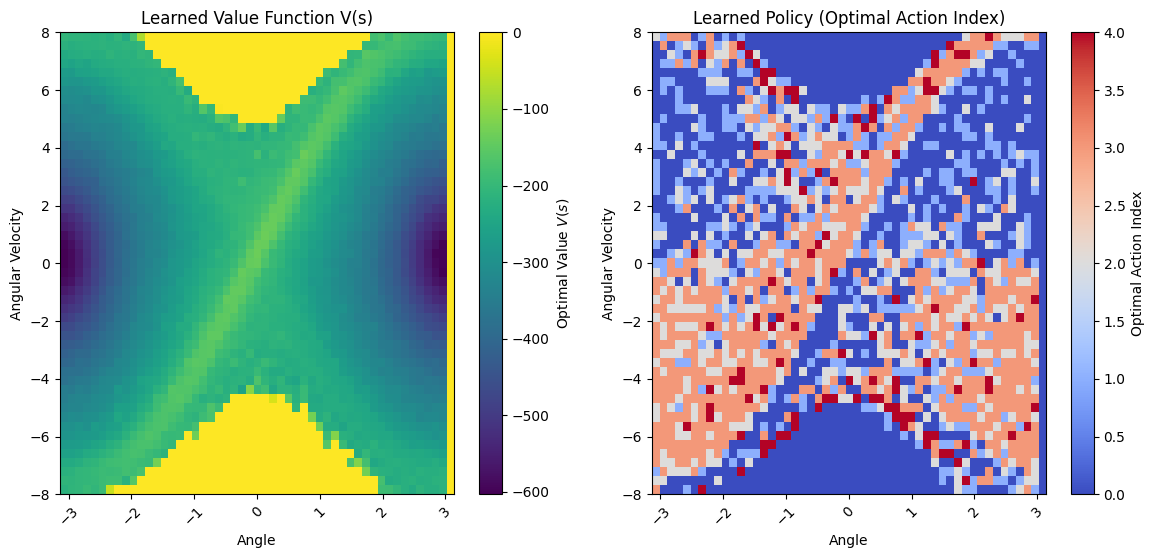

In [16]:
#ploting the value functino and policy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.imshow(np.max(Q, axis=2).T, cmap='viridis',   #V.T because V(num_theta_bins, num_theta_dot_bins) goes to (y , x)
           extent=[theta_bins.min(), theta_bins.max(), theta_dot_bins.min(), theta_dot_bins.max()],
           aspect='auto')
plt.colorbar(label='Optimal Value $V(s)$')
plt.xlabel('Angle')
plt.ylabel('Angular Velocity') 
plt.title('Learned Value Function V(s)')
plt.xticks(rotation=45) #x axis lable rotation

plt.subplot(1, 2, 2) #1 row, 2 columns, second plot
plt.imshow(Policy.T, cmap='coolwarm',
           extent=[theta_bins.min(), theta_bins.max(), theta_dot_bins.min(), theta_dot_bins.max()],
           aspect='auto')
plt.colorbar(label='Optimal Action Index')
plt.xlabel('Angle')
plt.ylabel('Angular Velocity')
plt.title('Learned Policy (Optimal Action Index)')
plt.xticks(rotation=45)

plt.show()